[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

# Time travel 时间旅行

## Review 回顾


我们讨论了引入人工参与 human-in-the-loop 的动机：

(1) **`审批`** - 我们可以中断代理，向用户展示状态，并允许用户接受某个操作

(2) **`调试`** - 我们可以回退图的执行，以复现或避免问题

(3) **`编辑`** - 你可以修改状态


我们展示了如何通过断点在特定节点停止图的执行，或者让图动态中断自身。

接着，我们展示了如何通过人工审批继续执行图，或者直接用人工反馈编辑图的状态。

## Goals 目标

现在，我们来展示 LangGraph 如何通过查看、重放，甚至从过去状态`分叉(forking)`来[支持调试](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/)。

我们称之为 **“时间旅行”**。

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

让我们建立一个 agent。

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

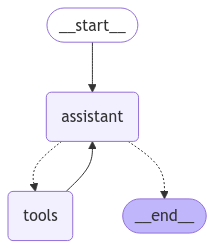

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

和之前一样，让我们运行它。

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dMfsExazU7ey8dLAs0LeEF6A)
 Call ID: call_dMfsExazU7ey8dLAs0LeEF6A
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## 浏览历史

我们可以使用 `get_state`，通过提供 `thread_id` 查看图的**当前**状态！

In [6]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dMfsExazU7ey8dLAs0LeEF6A', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1306b21e-b477-4cea-becb-bd9555164494-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_dMfsExazU7ey8dLAs0LeEF6A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

我们还可以浏览代理的状态历史。

使用 `get_state_history`，我们可以获取所有先前步骤的状态。

In [7]:
all_states = [s for s in graph.get_state_history(thread)]

In [8]:
len(all_states)

5

In [9]:
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dMfsExazU7ey8dLAs0LeEF6A', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1306b21e-b477-4cea-becb-bd9555164494-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_dMfsExazU7ey8dLAs0LeEF6A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 

第一个元素是当前状态，与我们从 `get_state` 获取的状态一致。

In [10]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd7d20-d0bc-693c-8000-d3c0ff9776bd'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-01-21T08:31:03.375461+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd7d20-d0aa-6228-bfff-cf686cdf6355'}}, tasks=(PregelTask(id='d8a9d3a6-d5e1-40c4-73e2-a8867921ac9f', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dMfsExazU7ey8dLAs0LeEF6A', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

把上面的步骤进行可视化：

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 重放

我们可以从任何先前步骤重新运行代理。

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

让我们回顾一下接收到人工输入的步骤！

In [11]:
to_replay = all_states[-2]

In [12]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd7d20-d0bc-693c-8000-d3c0ff9776bd'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-01-21T08:31:03.375461+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd7d20-d0aa-6228-bfff-cf686cdf6355'}}, tasks=(PregelTask(id='d8a9d3a6-d5e1-40c4-73e2-a8867921ac9f', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dMfsExazU7ey8dLAs0LeEF6A', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

查看状态

In [13]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115')]}

我们可以查看图运行的下一个节点。

In [14]:
to_replay.next

('assistant',)

我们还可以获取配置，其中包含 `checkpoint_id` 和 `thread_id` 信息。

In [15]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7d20-d0bc-693c-8000-d3c0ff9776bd'}}

要从这里重放，我们只需将配置传递回代理即可！

图会知道这个检查点已经被执行过。

它只会从这个检查点重新运行！

In [16]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_azhm73LrtzjYUeEqtXL8j8vx)
 Call ID: call_azhm73LrtzjYUeEqtXL8j8vx
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


现在，我们可以看到代理重新运行后的当前状态。

## Forking 分叉

如果我们想从相同的步骤开始运行，但使用不同的输入，该怎么办？

这就是分叉。

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [17]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115')]

同样，我们有配置文件。

In [18]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7d20-d0bc-693c-8000-d3c0ff9776bd'}}

让我们修改此检查点的状态。

我们只需运行 `update_state` 并提供 `checkpoint_id`。

回想一下我们的 `messages` 简化器 reducer 的工作方式：

- 它会追加，除非我们提供消息 ID。
- 如果提供了消息 ID，它将覆盖消息，而不是追加到状态！

因此，要覆盖消息，我们只需提供消息 ID，也就是 `to_fork.values["messages"].id`。

In [19]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [20]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7d5f-192f-69b0-8001-80fdf50a9f40'}}

这会创建一个新的分叉检查点。

但是，元数据（例如接下来要执行的节点）会被保留！

我们可以看到，agent 的当前状态已经更新为我们的分叉版本。

In [21]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115')]

In [22]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd7d5f-192f-69b0-8001-80fdf50a9f40'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='fb7d3556-5472-49b5-8f91-32a9d69d6115')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efd7d20-d0bc-693c-8000-d3c0ff9776bd'}, created_at='2025-01-21T08:58:55.272153+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd7d20-d0bc-693c-8000-d3c0ff9776bd'}}, tasks=(PregelTask(id='ce98cb8b-3a5e-74a6-054c-3341c767ceae', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

现在，当我们进行流式处理时，图会知道这个检查点从未被执行过。

因此，图会运行，而不是简单地重新播放。

In [23]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_9Z7nmm5O5xzLIiDYNJzgkUh7)
 Call ID: call_9Z7nmm5O5xzLIiDYNJzgkUh7
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The product of 5 and 3 is 15.


现在，我们可以看到当前状态是代理运行的结束状态。

In [21]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', id='4ee8c440-0e4a-47d7-852f-06e2a6c4f84d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KP2CVNMMUKMJAQuFmamHB21r', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bc420009-d1f6-49b8-bea7-dfc9fca7eb79-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_KP2CVNMMUKMJAQuFmamHB21r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 148}), ToolMessage(content='15', name='multiply', id='9232e653-816d-471a-9002-9a1ecd453364', tool_call_id='call_KP2CVNMMUKMJAQuFmamHB21r'), AIMessage(content='The result of multiplying 5 and 3 is 15.', additi

In [ ]:
# END